In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

print("PyTorch version:", torch.__version__)
print("CUDA is available:", torch.cuda.is_available())

!git clone https://github.com/SysCV/sam-hq.git
!pip install timm
os.chdir('sam-hq')
!export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamPredictor


PyTorch version: 2.0.1+cu118
CUDA is available: True
Cloning into 'sam-hq'...
remote: Enumerating objects: 368, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 368 (delta 66), reused 163 (delta 49), pack-reused 161
Receiving objects: 100% (368/368), 42.18 MiB | 17.70 MiB/s, done.
Resolving deltas: 100% (135/135), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.0 MB/s eta 0:00:00


In [ ]:
import sys
!{sys.executable} -m pip install onnx onnxruntime
from segment_anything.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 115.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.1 MB/s eta 0:00:00


In [ ]:
!mkdir pretrained_checkpoint
!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
!mv sam_hq_vit_l.pth pretrained_checkpoint


--2023-07-27 19:42:29--  https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
Resolving huggingface.co (huggingface.co)... 13.224.249.43, 13.224.249.10, 13.224.249.119, ...
Connecting to huggingface.co (huggingface.co)|13.224.249.43|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/d9/4e/d94e04992ac4e3ea45fcc1c523974540cdbef274e295d4aaacc69b4f19ee63b7/e1a6c385d62bf005ded91a54d5ec55c985cfc4103ef89c08d90f39f04934c343?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sam_hq_vit_l.pth%3B+filename%3D%22sam_hq_vit_l.pth%22%3B&Expires=1690746149&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5MDc0NjE0OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9kOS80ZS9kOTRlMDQ5OTJhYzRlM2VhNDVmY2MxYzUyMzk3NDU0MGNkYmVmMjc0ZTI5NWQ0YWFhY2M2OWI0ZjE5ZWU2M2I3L2UxYTZjMzg1ZDYyYmYwMDVkZWQ5MWE1NGQ1ZWM1NWM5ODVjZmM0MTAzZWY4OWMwOGQ5MGYzOWYwNDkzNGMzNDM%7EcmVzcG9

In [ ]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


def show_res(masks, scores, input_point, input_label, input_box, image):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        if input_box is not None:
            box = input_box[i]
            show_box(box, plt.gca())
        if (input_point is not None) and (input_label is not None):
            show_points(input_point, input_label, plt.gca())

        print(f"Score: {score:.3f}")
        plt.axis('off')
        plt.show()


def show_res_multi(masks, scores, input_point, input_label, input_box, image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask, plt.gca(), random_color=True)
    for box in input_box:
        show_box(box, plt.gca())
    for score in scores:
        print(f"Score: {score:.3f}")
    plt.axis('off')
    plt.show()


In [ ]:
sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_l.pth"
model_type = "vit_l"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

<All keys matched successfully>


# Export an ONNX model

The script segment-anything/scripts/export_onnx_model.py can be used to export the necessary portion of SAM. Alternatively, run the following code to export an ONNX model. If you have already exported a model, set the path below and skip to the next section. Assure that the exported ONNX model aligns with the checkpoint and model type set above. This notebook expects the model was exported with the parameter hq_token_only=True.

In [ ]:
onnx_model_path = None  # Set to use an already exported model, then skip to the next section.

In [ ]:
import warnings

sam.to(device='cpu')

onnx_model_path = "sam_onnx_example.onnx"

onnx_model = SamOnnxModel(sam, hq_token_only=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
encoder_embed_dim_dict = {"vit_b":768,"vit_l":1024,"vit_h":1280}
encoder_embed_dim = encoder_embed_dim_dict[model_type]
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "interm_embeddings": torch.randn(4, 1, *embed_size, encoder_embed_dim, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



If desired, the model can additionally be quantized and optimized. This improves web runtime significantly for negligible change in qualitative performance. Run the next cell to quantize the model, or skip to the next section otherwise.

In [ ]:
onnx_model_quantized_path = "sam_onnx_quantized_example.onnx"
quantize_dynamic(
    model_input=onnx_model_path,
    model_output=onnx_model_quantized_path,
    optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)
onnx_model_path = onnx_model_quantized_path

Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_image_to_token/MatMul]
Ignore Ma

# Example Image

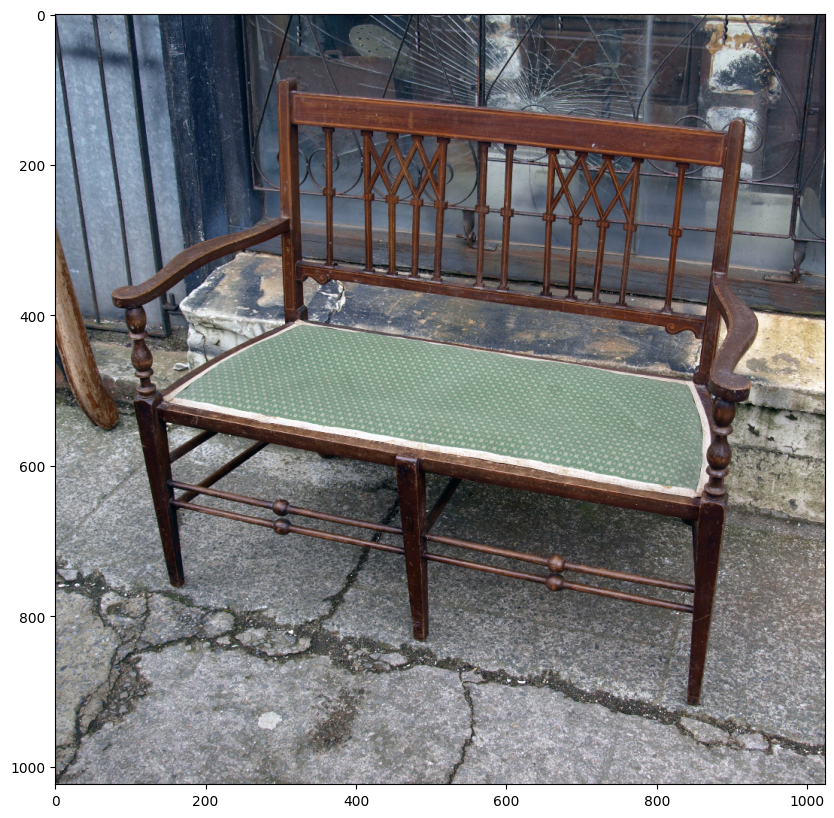

In [ ]:
image = cv2.imread('demo/input_imgs/example4.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

# Using an ONNX model

Here as an example, we use onnxruntime in python on CPU to execute the ONNX model. However, any platform that supports an ONNX runtime could be used in principle. Launch the runtime session below:

In [ ]:
ort_session = onnxruntime.InferenceSession(onnx_model_path)

To use the ONNX model, the image must first be pre-processed using the SAM image encoder. This is a heavier weight process best performed on GPU. SamPredictor can be used as normal, then .get_image_embedding() will retreive the intermediate features. And we also need early-layer features (interm_embeddings) for SAM-HQ.

In [ ]:
sam.to(device='cuda')
predictor = SamPredictor(sam)

predictor.set_image(image)
image_embedding = predictor.get_image_embedding().cpu().numpy()
interm_embeddings = torch.stack(predictor.interm_features).cpu().numpy()


The ONNX model has a different input signature than SamPredictor.predict. The following inputs must all be supplied. Note the special cases for both point and mask inputs. All inputs are np.float32.

* image_embeddings: The image embedding from predictor.get_image_embedding(). Has a batch index of length 1.
* point_coords: Coordinates of sparse input prompts, corresponding to both point inputs and box inputs. Boxes are encoded using two points, one for the top-left corner and one for the bottom-right corner. Coordinates must already be transformed to long-side 1024. Has a batch index of length 1.
* point_labels: Labels for the sparse input prompts. 0 is a negative input point, 1 is a positive input point, 2 is a top-left box corner, 3 is a bottom-right box corner, and -1 is a padding point. If there is no box input, a single padding point with label -1 and coordinates (0.0, 0.0) should be concatenated.
* mask_input: A mask input to the model with shape 1x1x256x256. This must be supplied even if there is no mask input. In this case, it can just be zeros.
* has_mask_input: An indicator for the mask input. 1 indicates a mask input, 0 indicates no mask input.
* orig_im_size: The size of the input image in (H,W) format, before any transformation.

Additionally, the ONNX model does not threshold the output mask logits. To obtain a binary mask, threshold at sam.mask_threshold (equal to 0.0).

In [ ]:
input_point = np.array([[500, 475]])
input_label = np.array([1])

onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

ort_inputs = {
    "image_embeddings": image_embedding,
    "interm_embeddings": interm_embeddings,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32),
}

In [ ]:
masks, _, low_res_logits = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

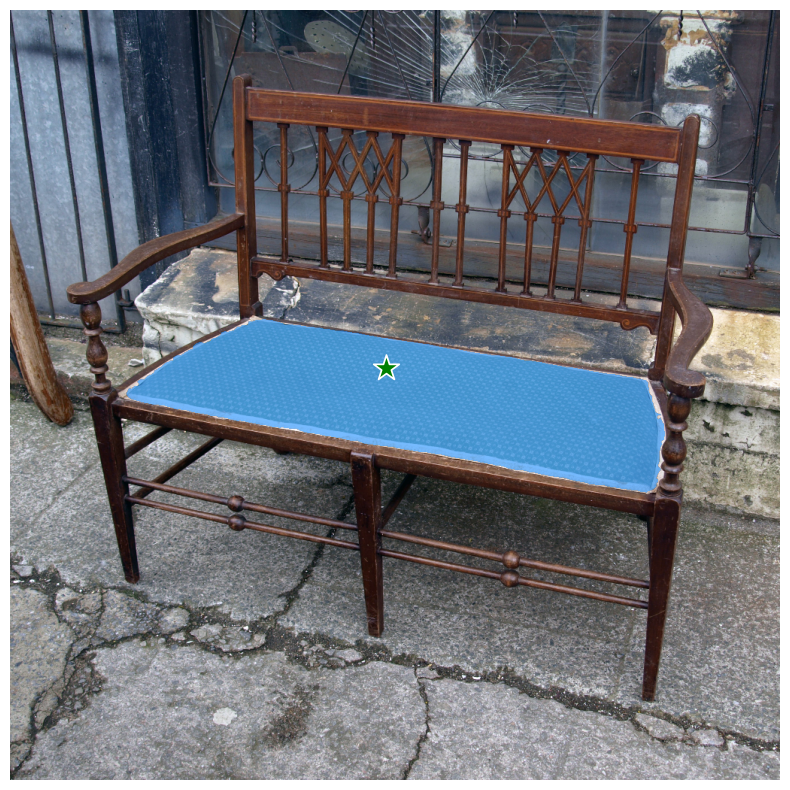

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [ ]:
input_box = np.array([64,76,940,919])

onnx_box_coords = input_box.reshape(2, 2)
onnx_box_labels = np.array([2,3])

onnx_coord = onnx_box_coords[None, :, :]
onnx_label = onnx_box_labels[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

In [ ]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

ort_inputs = {
    "image_embeddings": image_embedding,
    "interm_embeddings": interm_embeddings,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

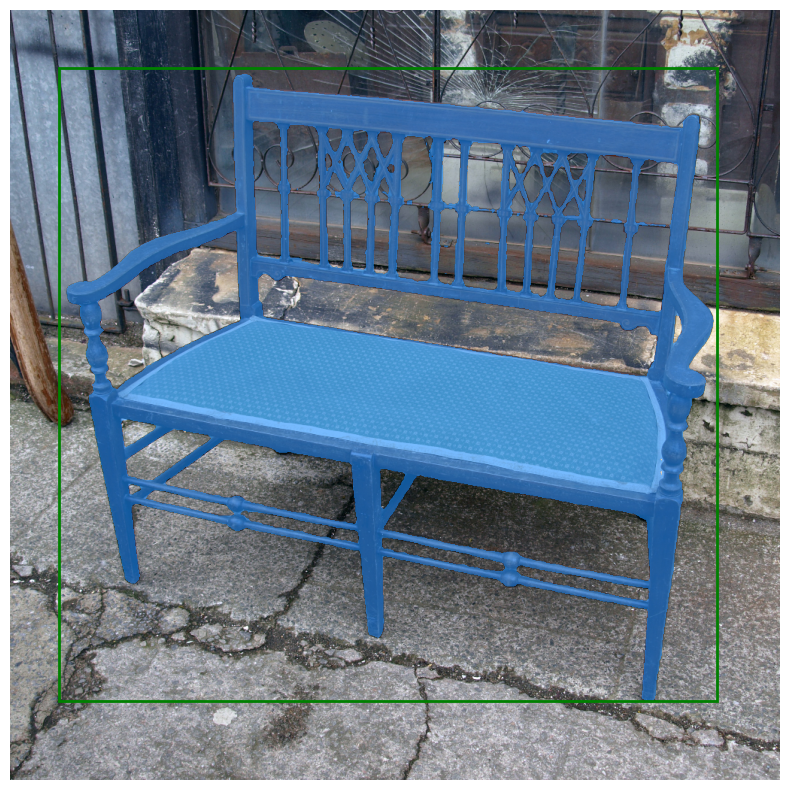

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

# (Optional) Multi-box input
To use multi-box prompt input, we need to re-export the ONNX model and change the dimension of the dummy input. Here we use 2-box input as an example

In [ ]:
import warnings

sam.to(device='cpu')

onnx_model_path = "sam_onnx_example.onnx"

onnx_model = SamOnnxModel(sam, hq_token_only=False)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
encoder_embed_dim_dict = {"vit_b":768,"vit_l":1024,"vit_h":1280}
encoder_embed_dim = encoder_embed_dim_dict[model_type]
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "interm_embeddings": torch.randn(4, 1, *embed_size, encoder_embed_dim, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(2, 5, 2), dtype=torch.float), # batch size of coords is 2 here
    "point_labels": torch.randint(low=0, high=4, size=(2, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



If desired, the model can additionally be quantized and optimized. This improves web runtime significantly for negligible change in qualitative performance. Run the next cell to quantize the model, or skip to the next section otherwise.

In [ ]:
onnx_model_quantized_path = "sam_onnx_quantized_example.onnx"
quantize_dynamic(
    model_input=onnx_model_path,
    model_output=onnx_model_quantized_path,
    optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)
onnx_model_path = onnx_model_quantized_path

Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_image_to_token/MatMul]
Ignore Ma

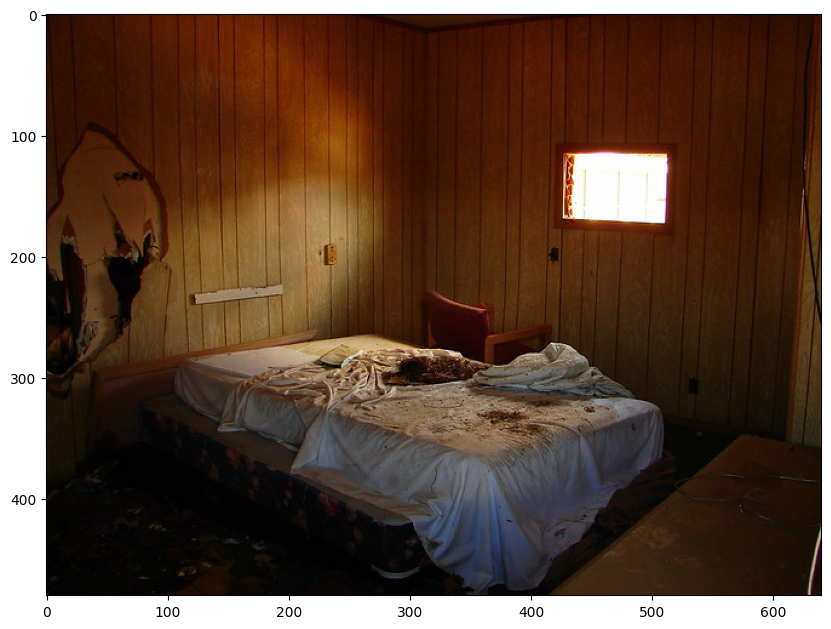

In [ ]:
image = cv2.imread('demo/input_imgs/example7.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [ ]:
ort_session = onnxruntime.InferenceSession(onnx_model_path)

In [ ]:
sam.to(device='cuda')
predictor = SamPredictor(sam)

predictor.set_image(image)
image_embedding = predictor.get_image_embedding().cpu().numpy()
interm_embeddings = torch.stack(predictor.interm_features).cpu().numpy()

In [ ]:
input_box = np.array([[45,260,515,470], [310,228,424,296]])

onnx_box_coords = input_box.reshape(2,2,2)
onnx_box_labels = np.array([2,3,2,3])

onnx_coord = onnx_box_coords
onnx_label = onnx_box_labels.reshape(2,2).astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

In [ ]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

ort_inputs = {
    "image_embeddings": image_embedding,
    "interm_embeddings": interm_embeddings,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

In [ ]:
masks.shape

(2, 1, 480, 640)

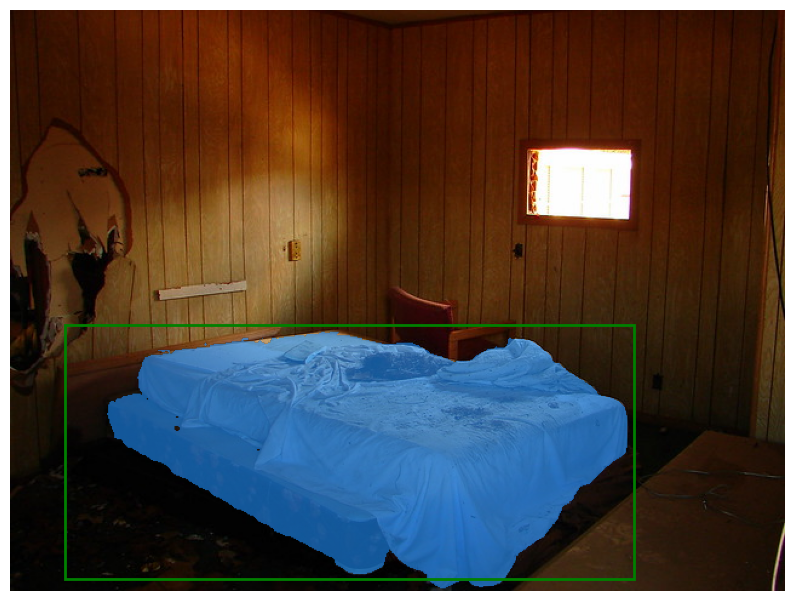

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box[0], plt.gca())
plt.axis('off')
plt.show()

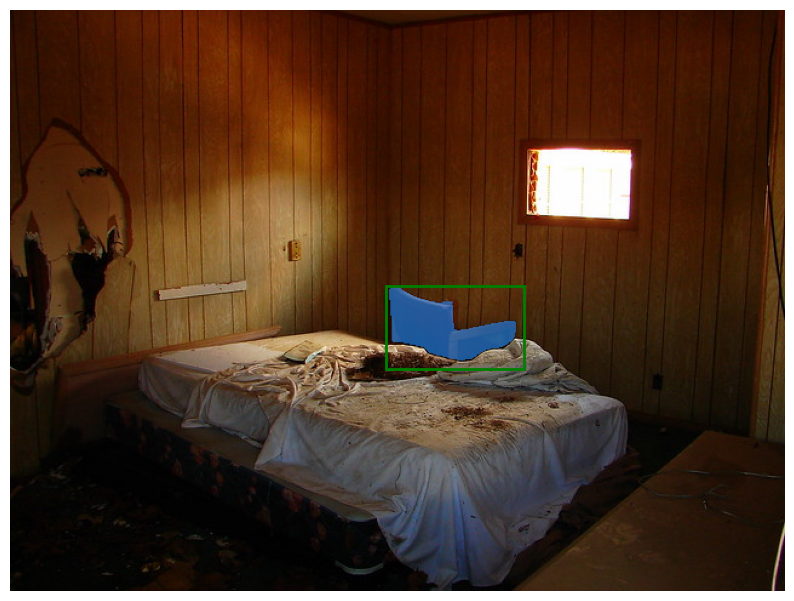

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[1], plt.gca())
show_box(input_box[1], plt.gca())
plt.axis('off')
plt.show()